# Working with Piecewise Continuous Functions: `IntervalData`

## Introduction

The `IntervalData` class is a subclass of `IntervalDict` class of `Portion`, used to hold and work with data (or function) that is piecewise continuous. The most obvious usecase is spectral data, where a continuous spectrum (for example from the Sun) can be then filtered in two distinct bands. The filters can be box filters (1.0 at the pass band, zero otherwise) or more complex filters with tapered edges.

When combined with interpolators and resampling, this provides a very powerful framework to simulate light (or generally radiofrequency) spectrum, interacting with filters or other surfaces that modify the amplitude and spectral properties as it goes through them or bounces off them.

We have to start with the opticks package import as well as some other useful packages.

In [1]:
# If opticks import fails, try to locate the module
# This can happen building the docs
import os

try:
    import opticks
except ModuleNotFoundError:
    os.chdir(os.path.join("..", "..", ".."))
    os.getcwd()

In [2]:
import numpy as np
import portion as P

from opticks import u, Q_

%matplotlib inline

# pint support to matplotlib
u.setup_matplotlib()

import warnings

warnings.filterwarnings("always")

## Initialising `IntervalData`

As a simple example, we start with a filter defined from -10 Hz to +10 Hz. It is transparent between -4 Hz and 0 Hz and between 2 Hz and 5 Hz. Outside the range of validity, the filter is undefined and returns `None`, inside the range of validity it returns zero where it is "non-transparent" and 1.0 where it is "transparent".

Also, there is no such thing as a negative frequency in the absolute sense, but it is possible in the relative sense. It matters little for this example, though may be worth mentioning for the sake of clarity.

In [3]:
from opticks.utils.interval_data import IntervalData

data = P.IntervalDict()
# interval of validity
validity = P.closed(-10 * u.Hz, 10 * u.Hz)
data[validity] = 0
# data proper
first_rng = P.closed(-4 * u.Hz, 0 * u.Hz)
data[first_rng] = 1.0
second_rng = P.closed(2 * u.Hz, 5 * u.Hz)
data[second_rng] = 1.0

filter = IntervalData(data)

# filter definition
print(filter)
# interval of validity
print(filter.domain())

# data inside interval of validity but zero
print(filter.get_value((8 * u.Hz)))
# data outside interval of validity
print(filter.get_value((12 * u.Hz)))

{[<Quantity(-10, 'hertz')>,<Quantity(-4, 'hertz')>) | (<Quantity(0, 'hertz')>,<Quantity(2, 'hertz')>) | (<Quantity(5, 'hertz')>,<Quantity(10, 'hertz')>]: 0, [<Quantity(-4, 'hertz')>,<Quantity(0, 'hertz')>] | [<Quantity(2, 'hertz')>,<Quantity(5, 'hertz')>]: 1.0}
[<Quantity(-10, 'hertz')>,<Quantity(10, 'hertz')>]
0.0
None


For something a bit more interesting, we will define a quadratic function, though we will take discrete steps and initialise an interpolator, rather than using the analytical function directly.

The data is defined from -8 to + 8 Hz, therefore shorter than the filter definition. This will be important later, when we apply the "filter" to this function.

In [4]:
from opticks.utils.math_utils import InterpolatorWithUnits, InterpolatorWithUnitTypes

target_range = P.closed(-8 * u.Hz, 8 * u.Hz)

x = np.linspace(target_range.lower, target_range.upper, num=100, endpoint=True)

y = (0.5 * x.m) ** 2

ipol = InterpolatorWithUnits.from_ipol_method(
    InterpolatorWithUnitTypes.AKIMA, x, y, extrapolate=True
)

main_funct = IntervalData.from_interpolator(ipol)

print(main_funct)

{[<Quantity(-8.0, 'hertz')>,<Quantity(8.0, 'hertz')>]: <opticks.utils.math_utils.InterpolatorWithUnits object at 0x7ed5572ac320>}


## Plotting the Data

The `IntervalDict` objects can be plotted easily. It is a `matplotlib` based convenience class for rapid visualisation and does not enable extensive customisation via the interface.

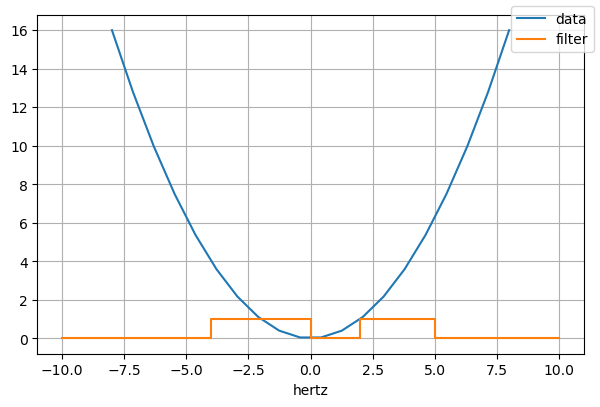

In [5]:
from opticks.utils.interval_data import IntervalDataPlot

interval_data_dict = {"data": main_funct, "filter": filter}

plot = IntervalDataPlot(interval_data_dict)

While the out-of-the-box formatting is sensible, it is possible to change things once the plot is populated. The `fig` and `ax` objects are also available for further customisation.

Text(0.5, 1.0, 'Filter and Data')

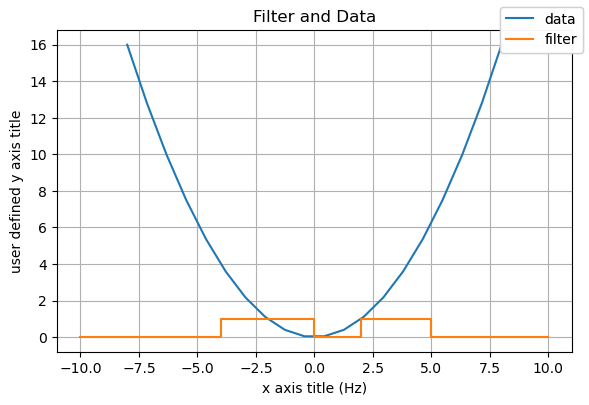

In [6]:
plot2 = IntervalDataPlot({"data": main_funct, "filter": filter})

# customisation via the limited convenience method
plot2.set_plot_style(
    xlabel="x axis title (Hz)",
    ylabel="user defined y axis title",
    height=10 * u.cm,
    width=15 * u.cm,
)

# customisation via the ax object
# example only, can be also done via set_plot_style
plot2.ax.set_title("Filter and Data")

It is possible to scale the `IntervalData` objects with a scalar. This is achieved via a `combine` operation under the hood (see the next section). We can plot the main function and a 1/2 scaling to see the end result.

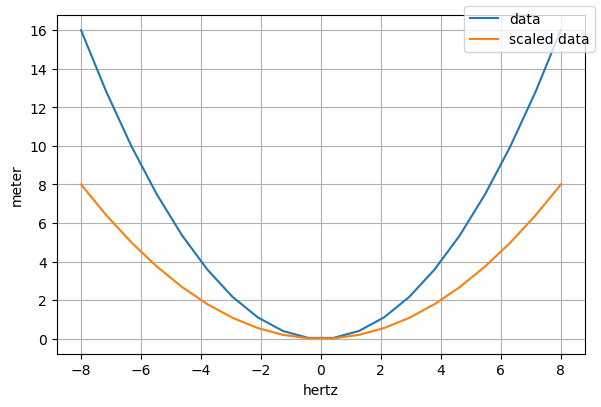

In [17]:
scaled_main = main_funct.scale(0.5)

interval_data_dict = {"data": main_funct, "scaled data": scaled_main}

plot = IntervalDataPlot(interval_data_dict)

## Combining `IntervalData` Objects

The next step is to `combine` the filter and the main function. This combine operation is defined as "stacking" the mathematical functions, interpolators or constants together in a list, for the proper internal regions of validity. Therefore, no resampling or evaluation actually takes place. The interpolators do not need to interpolate or extrapolate. The underlying `IntervalDict` implementation takes care of the interval arithmetic and knows the intersections.

Also, the region of validity for the combined `IntervalDict` is necessarily the intersection of the two, as the behaviour of `filter` or `main_funct` is not defined outside their respective regions of validity. The combined item still has the larger interval of validity, but these ranges yield `None` as the value. This behaviour can be changed with the `missing` key for the `combine` operation, but should be done cautiously.

To get the "stack" of functions at a certain point or region is possible using the `get` function. In this example, we have the interpolator and the value of 1.0.

In [8]:
from opticks.utils.interval_data import FunctCombinationMethod

filter.combination_method = FunctCombinationMethod.MULTIPLY
filtered_main = main_funct.combine(filter)

print(filtered_main)

# sample point x
x = 3 * u.Hz

# stack of functions at x
print(filtered_main.get(x))

{[<Quantity(-10, 'hertz')>,<Quantity(-8.0, 'hertz')>) | (<Quantity(8.0, 'hertz')>,<Quantity(10, 'hertz')>]: None, [<Quantity(-8.0, 'hertz')>,<Quantity(-4, 'hertz')>) | (<Quantity(0, 'hertz')>,<Quantity(2, 'hertz')>) | (<Quantity(5, 'hertz')>,<Quantity(8.0, 'hertz')>]: [<opticks.utils.math_utils.InterpolatorWithUnits object at 0x7ed5572ac320>, 0], [<Quantity(-4, 'hertz')>,<Quantity(0, 'hertz')>] | [<Quantity(2, 'hertz')>,<Quantity(5, 'hertz')>]: [<opticks.utils.math_utils.InterpolatorWithUnits object at 0x7ed5572ac320>, 1.0]}
[<opticks.utils.math_utils.InterpolatorWithUnits object at 0x7ed5572ac320>, 1.0]


In the example above, the combination method of the `filter` is set to `MULTIPLY`, before combining the two objects. The `combine` method does not define how the two `IntervalData` should be combined _arithmetically_. Therefore, when two `IntervalData` objects are combined and we would like to evaluate the data at a specific point, we have to define whether a multiplication or a summation operation is to be used.

When an `IntervalData` object is created, the default combination method is `UNDEFINED`. A combination is only possible between objects of compatible types. Objects of `SUM` types can be combined only with other objects of `SUM` or `UNDEFINED` types, where summation becomes the method for the entire combination sequence. The same logic goes for `MULTIPLY`, which can be combined only with `MULTIPLY` or `UNDEFINED` type objects. 

Note that, a `SUM` object cannot be combined with a `MULTIPLY` type object, as both might have various functions stacked and need to be evaluated with its own combination method. To combine such `IntervalData` objects, one of them should be resampled ([see below](#flattening-the-functions-stack-resampling)), making it `UNDEFINED` again. After resampling, they can be combined normally.

Similarly, an `UNDEFINED` object cannot be directly combined with another `UNDEFINED` object. One of them should be set to `SUM` or `MULTIPLY`, so that the combined object knows how to handle the combination.


In [9]:
# the combination type for the main function is by default undefined
print(main_funct.combination_method)

# the combination type for the combined filter is set to multiplication
print(filtered_main.combination_method)

FunctCombinationMethod.UNDEFINED
FunctCombinationMethod.MULTIPLY


Now that we defined how to combine the two `IntervalData` objects (in this case via multiplication), the `get_value` function evaluates all the "stacked" functions at the requested point and yields the result. 

In [10]:
# value at x (multiply all values at x)
print(filtered_main.get_value(x))

# stack of functions within the target range
target_range = P.closed(1 * u.Hz, 4 * u.Hz)
print(filtered_main.get(target_range))

2.2499999999999996
{[<Quantity(1, 'hertz')>,<Quantity(2, 'hertz')>): [<opticks.utils.math_utils.InterpolatorWithUnits object at 0x7ed5572ac320>, 0], [<Quantity(2, 'hertz')>,<Quantity(4, 'hertz')>]: [<opticks.utils.math_utils.InterpolatorWithUnits object at 0x7ed5572ac320>, 1.0]}


We can plot the resulting piecewise continuous function to see the effect of "filtering", or combining the two functions with a multiplication operation.

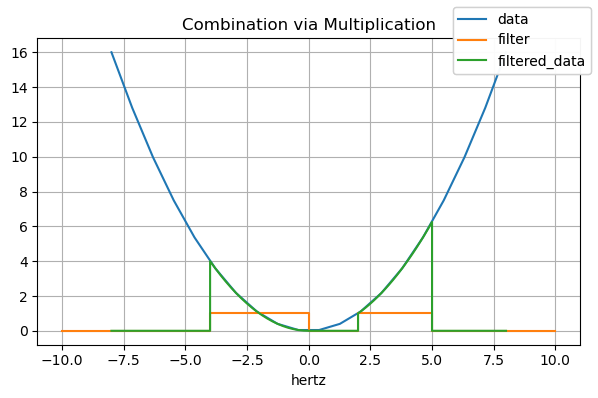

In [11]:
interval_data_dict = {
    "data": main_funct,
    "filter": filter,
    "filtered_data": filtered_main,
}

plot = IntervalDataPlot(interval_data_dict)

plot.set_plot_style(title="Combination via Multiplication")

To illustrate  how summation works, we will define another "filter" and combine with the first, explicitly defining a summation type combination. Then we can query any point on the list.

In [12]:
data = P.IntervalDict()
# interval of validity
validity = P.closed(-20 * u.Hz, 20 * u.Hz)
data[validity] = 0.1
# data proper
first_rng = P.closed(-8 * u.Hz, -6 * u.Hz)
data[first_rng] = 1.0
second_rng = P.closed(3 * u.Hz, 7 * u.Hz)
data[second_rng] = 1.0

# filter2 definition
filter2 = IntervalData(data)

# filter 2 output
print(filter2)

# combine the two filters
filter.combination_method = FunctCombinationMethod.SUM
combined_filter = filter2.combine(filter)


# combined filter output
print(combined_filter)

# value at x (sum all values at x)
x = 4.5 * u.Hz

print(combined_filter.get_value(x))

{[<Quantity(-20, 'hertz')>,<Quantity(-8, 'hertz')>) | (<Quantity(-6, 'hertz')>,<Quantity(3, 'hertz')>) | (<Quantity(7, 'hertz')>,<Quantity(20, 'hertz')>]: 0.1, [<Quantity(-8, 'hertz')>,<Quantity(-6, 'hertz')>] | [<Quantity(3, 'hertz')>,<Quantity(7, 'hertz')>]: 1.0}
{[<Quantity(-20, 'hertz')>,<Quantity(-10, 'hertz')>) | (<Quantity(10, 'hertz')>,<Quantity(20, 'hertz')>]: [0.1, None], [<Quantity(-10, 'hertz')>,<Quantity(-8, 'hertz')>) | (<Quantity(-6, 'hertz')>,<Quantity(-4, 'hertz')>) | (<Quantity(0, 'hertz')>,<Quantity(2, 'hertz')>) | (<Quantity(7, 'hertz')>,<Quantity(10, 'hertz')>]: [0.1, 0], [<Quantity(-8, 'hertz')>,<Quantity(-6, 'hertz')>] | (<Quantity(5, 'hertz')>,<Quantity(7, 'hertz')>]: [1.0, 0], [<Quantity(-4, 'hertz')>,<Quantity(0, 'hertz')>] | [<Quantity(2, 'hertz')>,<Quantity(3, 'hertz')>): [0.1, 1.0], [<Quantity(3, 'hertz')>,<Quantity(5, 'hertz')>]: [1.0, 1.0]}
2.0


It is useful to plot all three filters to visualise the end result.

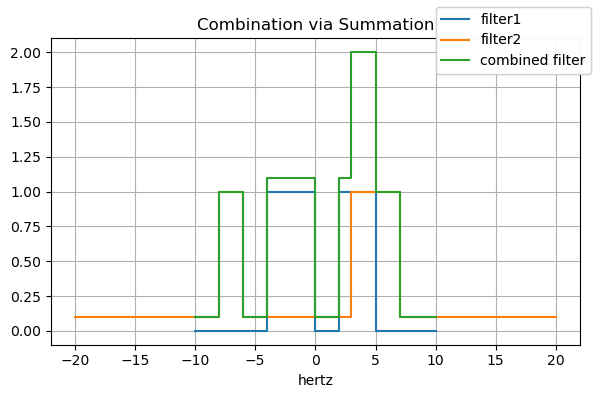

In [13]:
interval_data_dict = {
    "filter1": filter,
    "filter2": filter2,
    "combined filter": combined_filter,
}

plot = IntervalDataPlot(interval_data_dict)

plot.set_plot_style(title="Combination via Summation")

# Flattening the Functions Stack: Resampling

After successive `combine` operations, the functions stack can pile high, with multiple interpolations slowing down the operations. The `resample` function 'flattens' the stack, via a resampling and setting up a new interpolator.

The resampling is done for each *atomic* interval within the `IntervalData` object. This process decomposes all the intervals into atomic intervals, processes them and puts them back together into a new `IntervalData` object

The following example shows the atomic intervals.

In [14]:
# interval: funct view of the IntervalDict
atomic_int = filtered_main.as_atomic()

# List atomic intervals and corresponding functions
for interval, functs in atomic_int:
    print(interval, functs)

[<Quantity(-10, 'hertz')>,<Quantity(-8.0, 'hertz')>) None
(<Quantity(8.0, 'hertz')>,<Quantity(10, 'hertz')>] None
[<Quantity(-8.0, 'hertz')>,<Quantity(-4, 'hertz')>) [<opticks.utils.math_utils.InterpolatorWithUnits object at 0x7ed5572ac320>, 0]
(<Quantity(0, 'hertz')>,<Quantity(2, 'hertz')>) [<opticks.utils.math_utils.InterpolatorWithUnits object at 0x7ed5572ac320>, 0]
(<Quantity(5, 'hertz')>,<Quantity(8.0, 'hertz')>] [<opticks.utils.math_utils.InterpolatorWithUnits object at 0x7ed5572ac320>, 0]
[<Quantity(-4, 'hertz')>,<Quantity(0, 'hertz')>] [<opticks.utils.math_utils.InterpolatorWithUnits object at 0x7ed5572ac320>, 1.0]
[<Quantity(2, 'hertz')>,<Quantity(5, 'hertz')>] [<opticks.utils.math_utils.InterpolatorWithUnits object at 0x7ed5572ac320>, 1.0]


The resampling is carried out respecting the content of the functions stack at each atomic interval. Assuming a `MULTIPLY` type stack:
- If one item of the functions stack is `None`, then the entire interval value is set to `None`
- If one item of the functions stack is zero, then the entire interval value is set to zero.
- If all the items of the functions stack are numbers, then the entire interval value is set to the multiplication of these numbers.
- Finally, if one item of the multiple item functions stack is a continuous function or interpolator, then the entire interval value is resampled.

In this example, the resampling for the first two intervals in the list would automatically result in `None`, the next three intervals automatically zero and the last two intervals would be resampled.

A `SUM` type stack would be handled similarly, with summation of the stacked values instead of multiplication.

The sample sizes are important only when an interpolation is needed. The `approx_stepsize` argument instructs the method to set the sample size accordingly. The approximate part comes from the fact that, the samples are computed by dividing the interval by the stepsize and rounding down to convert them into integers.

In [15]:
approx_stepsize = 0.15 * u.Hz

resampled_filt_main = filtered_main.resample(approx_stepsize)

# original
print(filtered_main)

# resampled
print(resampled_filt_main)

{[<Quantity(-10, 'hertz')>,<Quantity(-8.0, 'hertz')>) | (<Quantity(8.0, 'hertz')>,<Quantity(10, 'hertz')>]: None, [<Quantity(-8.0, 'hertz')>,<Quantity(-4, 'hertz')>) | (<Quantity(0, 'hertz')>,<Quantity(2, 'hertz')>) | (<Quantity(5, 'hertz')>,<Quantity(8.0, 'hertz')>]: [<opticks.utils.math_utils.InterpolatorWithUnits object at 0x7ed5572ac320>, 0], [<Quantity(-4, 'hertz')>,<Quantity(0, 'hertz')>] | [<Quantity(2, 'hertz')>,<Quantity(5, 'hertz')>]: [<opticks.utils.math_utils.InterpolatorWithUnits object at 0x7ed5572ac320>, 1.0]}
{[<Quantity(-10, 'hertz')>,<Quantity(-8.0, 'hertz')>) | (<Quantity(8.0, 'hertz')>,<Quantity(10, 'hertz')>]: None, [<Quantity(-8.0, 'hertz')>,<Quantity(-4, 'hertz')>) | (<Quantity(0, 'hertz')>,<Quantity(2, 'hertz')>) | (<Quantity(5, 'hertz')>,<Quantity(8.0, 'hertz')>]: 0, [<Quantity(-4, 'hertz')>,<Quantity(0, 'hertz')>]: <opticks.utils.math_utils.InterpolatorWithUnits object at 0x7ed54edde0d0>, [<Quantity(2, 'hertz')>,<Quantity(5, 'hertz')>]: <opticks.utils.math_uti

Inspecting the output, we can see that the intervals with `None` and zero are still merged as a single, non-atomic interval, whereas the interpolated interval is now made up of two non-adjacent parts.

We can plot all three functions to inspect the results visually.

Text(0.5, 1.0, 'Filter and Filtered Data')

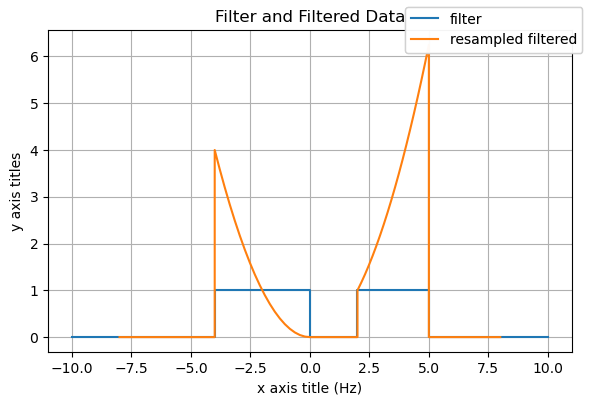

In [16]:
plot2 = IntervalDataPlot({"filter": filter, "resampled filtered": resampled_filt_main})
plot2.set_plot_style(
    xlabel="x axis title (Hz)",
    ylabel="y axis titles",
    height=10 * u.cm,
    width=15 * u.cm,
)

# example only, can be also done via set_plot_style
plot2.ax.set_title("Filter and Filtered Data")